In [ ]:
!pip install sdv

^C


   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
    --------------------------------------- 0.3/14.6 MB ? eta -:--:--
   -- ------------------------------------- 1.0/14.6 MB 2.8 MB/s eta 0:00:05
   ----- ---------------------------------- 1.8/14.6 MB 3.6 MB/s eta 0:00:04
   ------- -------------------------------- 2.6/14.6 MB 3.5 MB/s eta 0:00:04
   --------- ------------------------------ 3.4/14.6 MB 3.6 MB/s eta 0:00:04
   ------------ --------------------------- 4.5/14.6 MB 3.9 MB/s eta 0:00:03
   --------------- ------------------------ 5.5/14.6 MB 4.0 MB/s eta 0:00:03
   ------------------ --------------------- 6.8/14.6 MB 4.3 MB/s eta 0:00:02
   --------------------- ------------------ 7.9/14.6 MB 4.3 MB/s eta 0:00:02
   ------------------------ --------------- 8.9/14.6 MB 4.5 MB/s eta 0:00:02
   ---------------------------- ----------- 10.2/14.6 MB 4.6 MB/s eta 0:00:01
   ------------------------------ --------- 11.0/14.6 MB 4.6 MB/s eta 0:00:01
   --------

In [ ]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import pandas as pd
import random

#Fetch Data
url = "https://raw.githubusercontent.com/shrikant-temburwar/Loan-Prediction-Dataset/master/train.csv"
df = pd.read_csv(url)

df = df[['Gender', 'Education', 'Self_Employed', 'ApplicantIncome',
         'CoapplicantIncome', 'LoanAmount', 'Credit_History',
         'Property_Area', 'Loan_Status']]

#Clean
df = df.dropna()
df['Credit_History'] = df['Credit_History'].astype(str)

#Train CTGAN
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)
model = CTGANSynthesizer(metadata)
model.fit(df)

#Generate 1000 Synthetic Records
synthetic_data = model.sample(1000)

reasons = [
    "I need to renovate my house immediately.",
    "Planning to expand my small business operations.",
    "Urgent medical expenses covered by loan.",
    "Buying a new car for daily commute.",
    "Consolidating high-interest debts.",
    "Investment in a new startup opportunity."
]

qualifiers = [
    "I am very confident in repayment.",
    "I might struggle slightly initially.",
    "Business is booming right now.",
    "Facing some financial stress currently."
]

def generate_text(row):
    reason = random.choice(reasons)
    if row['ApplicantIncome'] > 10000:
        qualifier = "I am very confident in repayment."
    else:
        qualifier = random.choice(qualifiers)
    return f"{reason} {qualifier}"

synthetic_data['Application_Note'] = synthetic_data.apply(generate_text, axis=1)

#Save
print(synthetic_data.head())
synthetic_data.to_csv('synthetic_financial_data_enhanced.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


   Gender     Education Self_Employed  ApplicantIncome  CoapplicantIncome  \
0    Male      Graduate            No             1969           0.000000   
1    Male  Not Graduate            No             1544           0.000000   
2    Male      Graduate            No              388         345.682079   
3    Male  Not Graduate           Yes              150         145.880326   
4  Female      Graduate           Yes             1691          32.047091   

   LoanAmount Credit_History Property_Area Loan_Status  \
0       247.0            0.0         Rural           N   
1       268.0            1.0     Semiurban           Y   
2       121.0            1.0     Semiurban           Y   
3       216.0            1.0     Semiurban           Y   
4       103.0            1.0         Rural           N   

                                    Application_Note  
0  Urgent medical expenses covered by loan. Facin...  
1  Urgent medical expenses covered by loan. Busin...  
2  Buying a new car for

In [ ]:
# Load the dataset
import pandas as pd
import numpy as np

# Load the CSV file
data = pd.read_csv('/kaggle/input/wie3007-dataset/synthetic_financial_data_enhanced.csv')

# Check for missing values
missing_summary = data.isnull().sum()
print("Missing Values Summary:")
print(missing_summary)


Missing Values Summary:
Gender               0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Credit_History       0
Property_Area        0
Loan_Status          0
Application_Note     0
dtype: int64


In [ ]:
categorical_cols = [
    'Gender', 'Education', 'Self_Employed',
    'Property_Area', 'Loan_Status'
]

df[categorical_cols] = df[categorical_cols].astype(object)

In [ ]:
# Total household income
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Loan to income ratio (add 1 to avoid division by zero)
df['LoanIncomeRatio'] = df['LoanAmount'] / (df['TotalIncome'] + 1)

In [ ]:
df['HasCreditHistory'] = df['Credit_History'].apply(
    lambda x: 1 if x == 1 else 0
)

In [ ]:
df['Employment_Type'] = df['Self_Employed'].map({
    'Yes': 'Self_Employed',
    'No': 'Salaried'
})

In [ ]:
df['IncomeLevel'] = pd.cut(
    df['TotalIncome'],
    bins=[0, 2000, 5000, 10000, df['TotalIncome'].max()],
    labels=['Low', 'Medium', 'High', 'Very High']
)

In [ ]:
df['Note_Length'] = df['Application_Note'].str.len()

# Risk keyword flag
risk_keywords = ['urgent', 'debt', 'medical', 'delay', 'struggle']

df['Risk_Keyword_Flag'] = df['Application_Note'].str.lower().apply(
    lambda x: 1 if any(word in x for word in risk_keywords) else 0
)

In [ ]:
encode_cols = [
    'Gender', 'Education', 'Employment_Type',
    'Property_Area', 'IncomeLevel'
]

df_model = pd.get_dummies(df, columns=encode_cols, drop_first=True)

print("Final feature set shape:", df_model.shape)
df_model.head()

Final feature set shape: (1000, 20)


,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Loan_Status,Application_Note,TotalIncome,LoanIncomeRatio,HasCreditHistory,Note_Length,Risk_Keyword_Flag,Gender_Male,Education_Not Graduate,Employment_Type_Self_Employed,Property_Area_Semiurban,Property_Area_Urban,IncomeLevel_Medium,IncomeLevel_High,IncomeLevel_Very High
0,No,1969,0.000000,247.0,0.0,N,Urgent medical expenses covered by loan. Facin...,1969.000000,0.125381,0,80,1,True,False,False,False,False,False,False,False
1,No,1544,0.000000,268.0,1.0,Y,Urgent medical expenses covered by loan. Busin...,1544.000000,0.173463,1,71,1,True,True,False,True,False,False,False,False
2,No,388,345.682079,121.0,1.0,Y,Buying a new car for daily commute. I might st...,733.682079,0.164697,1,72,1,True,False,False,True,False,False,False,False
3,Yes,150,145.880326,216.0,1.0,Y,I need to renovate my house immediately. Facin...,295.880326,0.727566,1,80,0,True,True,True,True,False,False,False,False
4,Yes,1691,32.047091,103.0,1.0,N,Planning to expand my small business operation...,1723.047091,0.059743,1,88,0,False,False,True,False,False,False,False,False


In [ ]:
df_model.to_csv("synthetic_financial_data_feature_engineered.csv", index=False)
print("Feature-engineered dataset saved successfully.")

Feature-engineered dataset saved successfully.


In [2]:
import pandas as pd
raw_df = pd.read_csv("synthetic_financial_data_feature_engineered.csv")

# Check for redundancy/multicollinearity
# Self_Employed and Employment_Type_Self_Employed
# Credit_History and HasCreditHistory
redundancy_check_1 = pd.crosstab(raw_df['Self_Employed'], raw_df['Employment_Type_Self_Employed'])
redundancy_check_2 = pd.crosstab(raw_df['Credit_History'], raw_df['HasCreditHistory'])
print("\nRedundancy Check (Self_Employed vs Employment_Type):")
print(redundancy_check_1)
print("\nRedundancy Check (Credit_History vs HasCreditHistory):")
print(redundancy_check_2)


Redundancy Check (Self_Employed vs Employment_Type):
Employment_Type_Self_Employed  False  True 
Self_Employed                              
No                               817      0
Yes                                0    183

Redundancy Check (Credit_History vs HasCreditHistory):
HasCreditHistory    0    1
Credit_History            
0.0               198    0
1.0                 0  802


In [3]:
# Drop redundant columns
cols_to_drop = ['Self_Employed', 'Credit_History']
check_df = raw_df.drop(columns=cols_to_drop)

In [4]:
import numpy as np

# 1. Row count check
print(f"Rows: {len(check_df)} / 1000")

# 2. Check Empty cells
print(f"Empty cells: {check_df.isnull().sum().sum()}")

# 3. Check math errors
inf_errors = np.isinf(check_df['LoanIncomeRatio']).sum()
print(f"Math errors (Infinity): {inf_errors}")

Rows: 1000 / 1000
Empty cells: 0
Math errors (Infinity): 0


In [5]:
check_df.to_csv('final_synthetic_financial_data_feature_engineered.csv', index=False)

In [2]:
import pandas as pd

df = pd.read_csv("/kaggle/input/latest-wie3007/final_synthetic_financial_data_feature_engineered.csv")


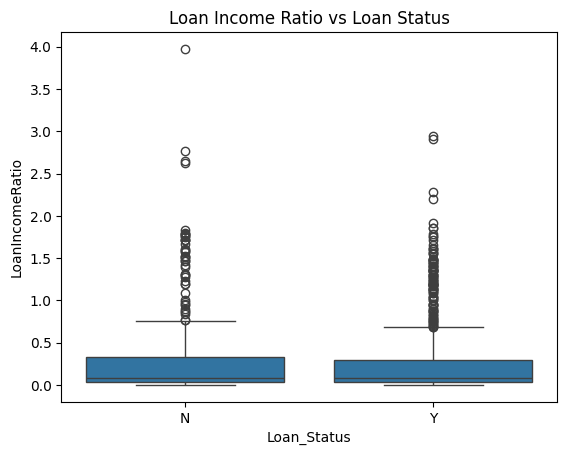

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='Loan_Status', y='LoanIncomeRatio', data=df)
plt.title("Loan Income Ratio vs Loan Status")
plt.show()


The boxplot shows that applicants with lower loan-to-income ratios are more likely to have their loans approved. Rejected applications tend to exhibit higher variability and extreme values, indicating that repayment capacity plays an important role in loan approval decisions.

### FEATURE IMPORTANCE ANALYSIS
Using Random Forest to determine feature importance for Loan_Status prediction.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features and target
# Drop non-numeric columns for modeling
X = df.drop(columns=['Loan_Status', 'Application_Note'])
y = df['Loan_Status']

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Y=1, N=0

print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(f"  Y (Approved): {sum(y_encoded)} ({sum(y_encoded)/len(y_encoded)*100:.1f}%)")
print(f"  N (Rejected): {len(y_encoded) - sum(y_encoded)} ({(len(y_encoded) - sum(y_encoded))/len(y_encoded)*100:.1f}%)")

Features shape: (1000, 16)
Target distribution:
  Y (Approved): 689 (68.9%)
  N (Rejected): 311 (31.1%)


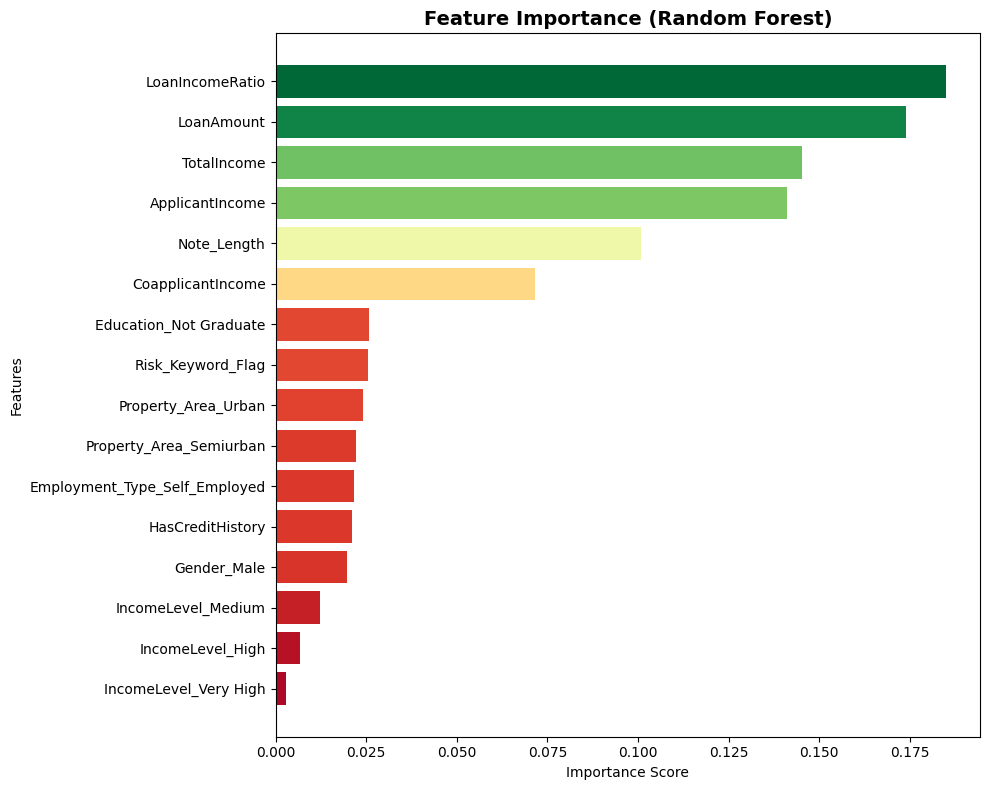


Top 10 Most Important Features:
                feature  importance
Property_Area_Semiurban    0.022326
    Property_Area_Urban    0.024269
      Risk_Keyword_Flag    0.025397
 Education_Not Graduate    0.025755
      CoapplicantIncome    0.071525
            Note_Length    0.100846
        ApplicantIncome    0.141041
            TotalIncome    0.145141
             LoanAmount    0.173930
        LoanIncomeRatio    0.185127


In [4]:
# Feature Importance using Random Forest
# Using class_weight='balanced' to handle class imbalance
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X, y_encoded)

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 8))
colors = plt.cm.RdYlGn(importance_df['importance'] / importance_df['importance'].max())
plt.barh(importance_df['feature'], importance_df['importance'], color=colors)
plt.title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Display top features
print("\nTop 10 Most Important Features:")
print(importance_df.tail(10).to_string(index=False))

### FEATURE SELECTION
Selecting features based on importance scores. Features with importance > mean importance are selected.

In [5]:
# Feature Selection based on importance threshold
importance_threshold = importance_df['importance'].mean()
print(f"Mean importance: {importance_threshold:.4f}")

# Select features above threshold
selected_features = importance_df[importance_df['importance'] > importance_threshold]['feature'].tolist()
print(f"\nSelected {len(selected_features)} features (above mean importance):")
for i, feat in enumerate(selected_features, 1):
    importance_val = importance_df[importance_df['feature'] == feat]['importance'].values[0]
    print(f"  {i}. {feat}: {importance_val:.4f}")

# Create selected feature matrix
X_selected = X[selected_features]
print(f"\nSelected features shape: {X_selected.shape}")

Mean importance: 0.0625

Selected 6 features (above mean importance):
  1. CoapplicantIncome: 0.0715
  2. Note_Length: 0.1008
  3. ApplicantIncome: 0.1410
  4. TotalIncome: 0.1451
  5. LoanAmount: 0.1739
  6. LoanIncomeRatio: 0.1851

Selected features shape: (1000, 6)


In [ ]:
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_selected, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)

# Second split: 50% of temp for val, 50% for test (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Data Split Summary:")
print(f"  Training:   {len(X_train):4d} samples ({len(X_train)/len(X_selected)*100:.1f}%)")
print(f"  Validation: {len(X_val):4d} samples ({len(X_val)/len(X_selected)*100:.1f}%)")
print(f"  Test:       {len(X_test):4d} samples ({len(X_test)/len(X_selected)*100:.1f}%)")

print(f"\nClass Distribution (Y=Approved, N=Rejected):")
print(f"  Training:   Y={sum(y_train)}, N={len(y_train)-sum(y_train)} ({sum(y_train)/len(y_train)*100:.1f}% approved)")
print(f"  Validation: Y={sum(y_val)}, N={len(y_val)-sum(y_val)} ({sum(y_val)/len(y_val)*100:.1f}% approved)")
print(f"  Test:       Y={sum(y_test)}, N={len(y_test)-sum(y_test)} ({sum(y_test)/len(y_test)*100:.1f}% approved)")